# 1 - Importar libs e carregar os DataFrames

In [1]:
# general imports
import seaborn as sns
import numpy as np
import pandas as pd

# custom libs
from bibliotecas.eda import *

# geographic 
import matplotlib.pyplot as plt
import geobr

%matplotlib inline

# warnings option
import warnings
warnings.filterwarnings('ignore')

# 2 - Lendo Arquivos

In [2]:
df_covid = pd.read_pickle('dados/cleaned/df_nonan.pkl')
df_idh = pd.read_pickle('dados/cleaned/df_idh.pkl')
df_populacao = pd.read_excel('dados/cleaned/pop_saopaulo.xlsx')

# 3 - EDA

In [3]:
target = 'obito'
disc_cols = ['cs_sexo', 'nome_munic', 
             'codigo_ibge','asma', 'cardiopatia',
             'diabetes','doenca_hematologica', 'doenca_hepatica',
             'doenca_neurologica','doenca_renal', 'imunodepressao',
             'obesidade','outros_fatores_de_risco', 'pneumopatia',
             'puerpera','sindrome_de_down']
cont_cols = ['idade', 'ano_inicio_sintomas', 'mes_inicio_sintomas', 'ano_mes_inicio_sintomas']

In [4]:
EDA_values(df_covid)


  0 | nome_munic               |  Min: adamantina | Max: zacarias
  1 | codigo_ibge              |  Min: 3500105 | Max: 3599999
  2 | idade                    |  Min: 0.0 | Max: 110.0
  3 | cs_sexo                  |  ['MASCULINO' 'FEMININO']
  4 | data_inicio_sintomas     |  Min: 2020-02-04T00:00:00Z | Max: 2021-11-05T00:00:00Z
  5 | obito                    |  [0 1]
  6 | asma                     |  ['IGNORADO' 'NÃO' 'SIM']
  7 | cardiopatia              |  ['IGNORADO' 'SIM' 'NÃO']
  8 | diabetes                 |  ['IGNORADO' 'NÃO' 'SIM']
  9 | doenca_hematologica      |  ['IGNORADO' 'NÃO' 'SIM']
 10 | doenca_hepatica          |  ['IGNORADO' 'NÃO' 'SIM']
 11 | doenca_neurologica       |  ['IGNORADO' 'NÃO' 'SIM']
 12 | doenca_renal             |  ['IGNORADO' 'NÃO' 'SIM']
 13 | imunodepressao           |  ['IGNORADO' 'NÃO' 'SIM']
 14 | obesidade                |  ['IGNORADO' 'NÃO' 'SIM']
 15 | outros_fatores_de_risco  |  ['IGNORADO' 'NÃO' 'SIM']
 16 | pneumopatia              |  ['IG

In [5]:
EDA_values(df_idh)


 0 | nome_munic  |  Min: adamantina | Max: zacarias
 1 | idh         |  Min: 0.592 | Max: 0.891


In [6]:
EDA_values(df_populacao)


 0 | codigo_ibge      |  Min: 3500105 | Max: 3557303
 1 | media_pop_5anos  |  Min: 837.8 | Max: 12251482.6


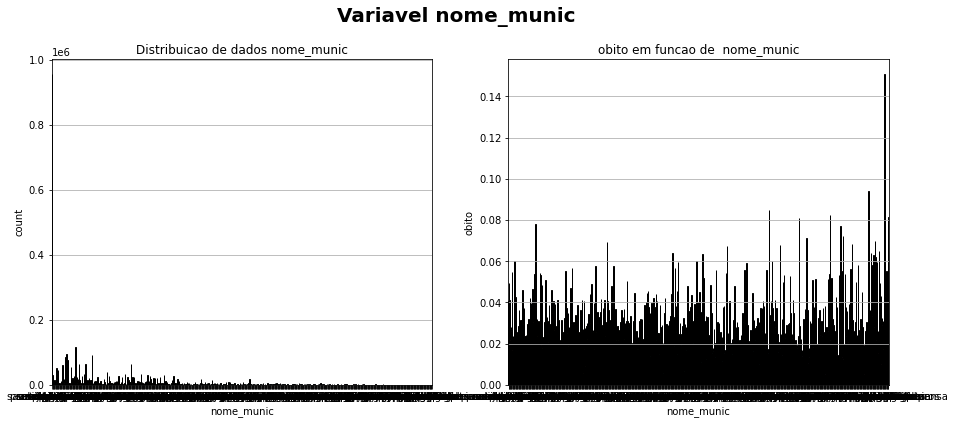

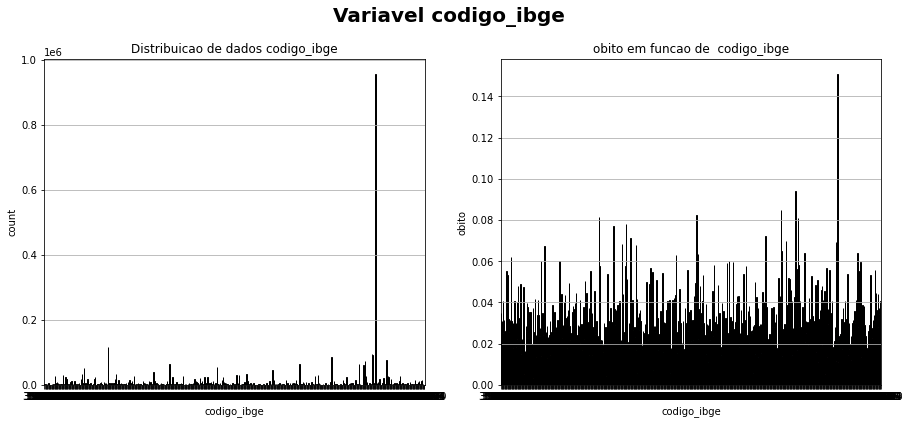

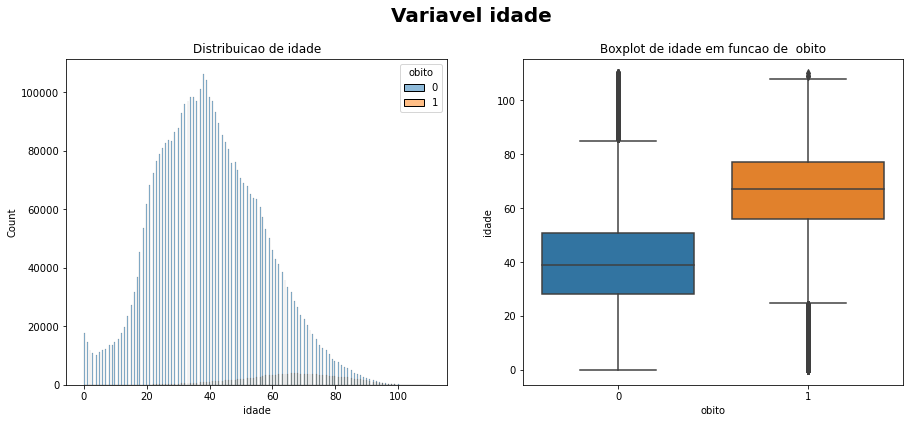

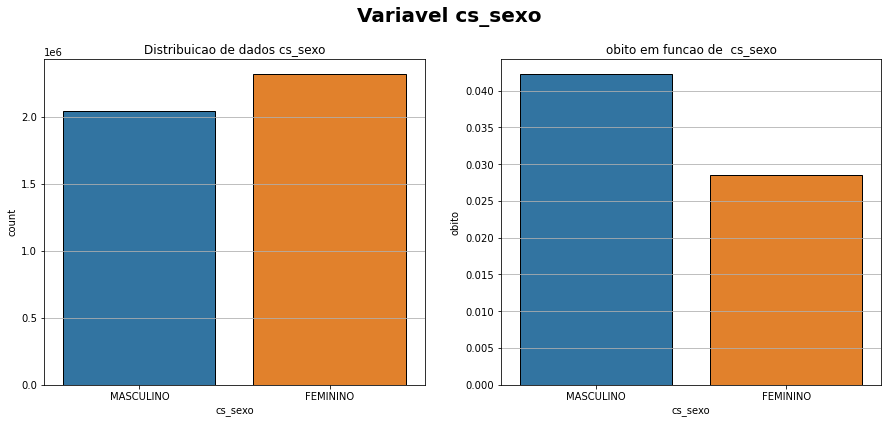

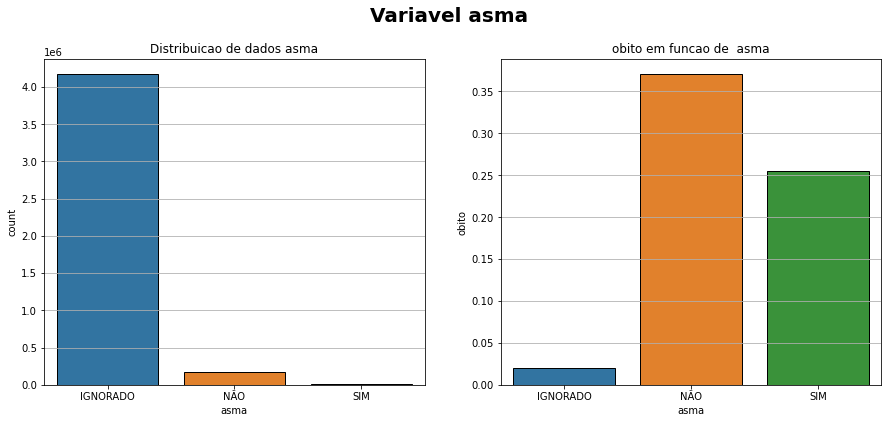

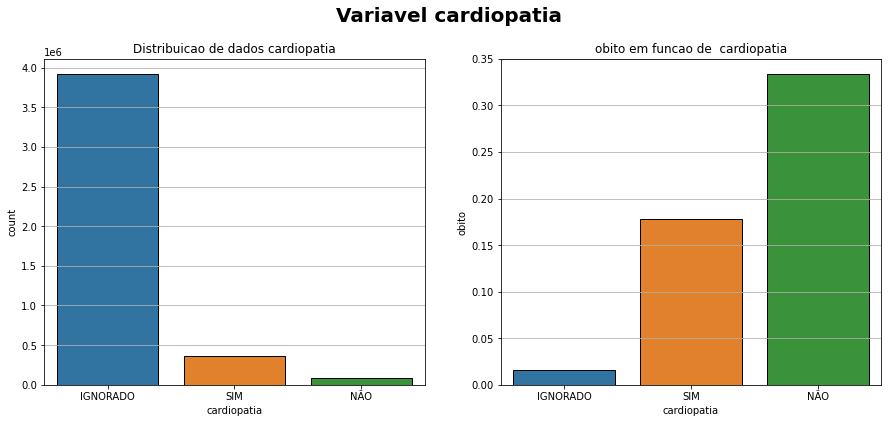

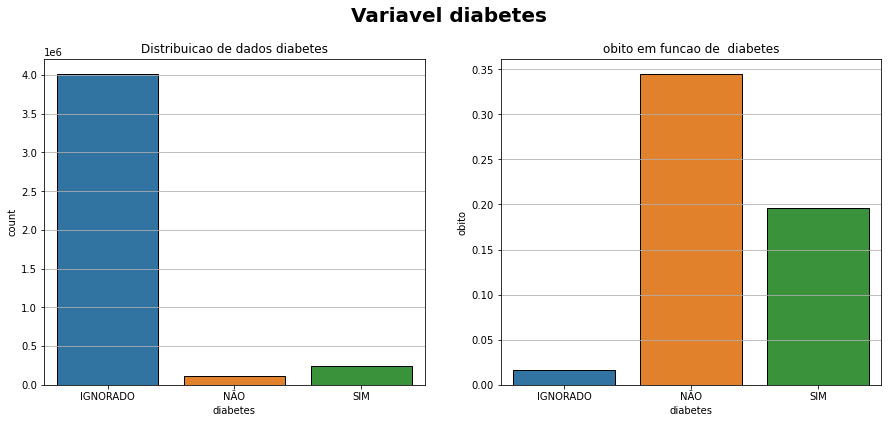

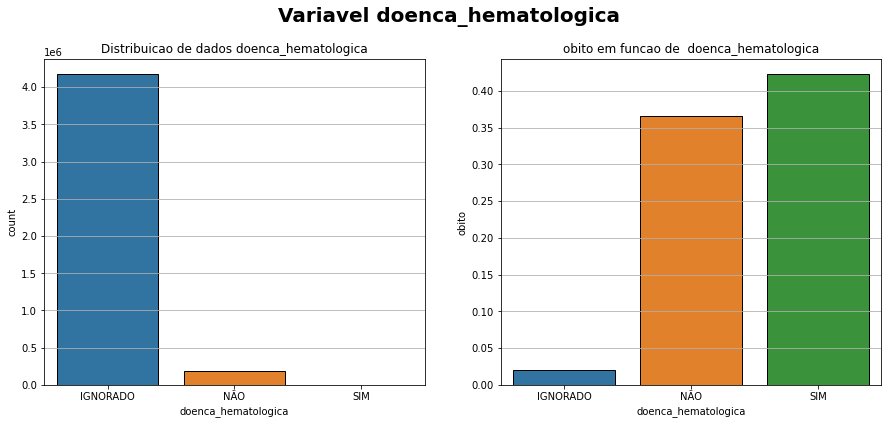

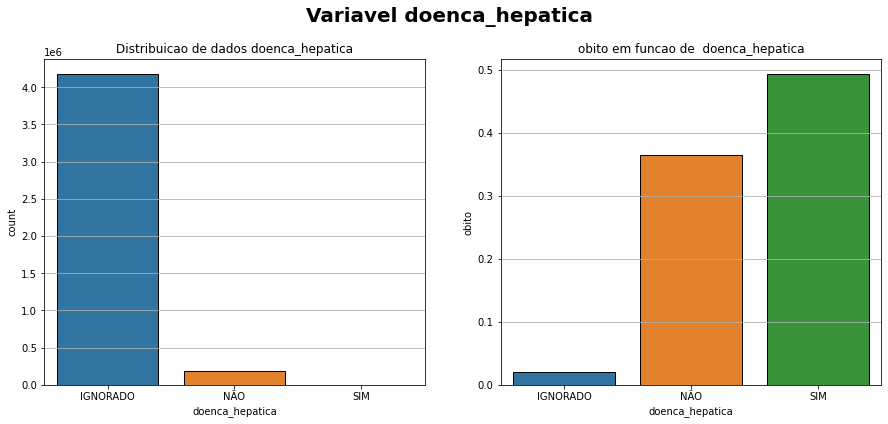

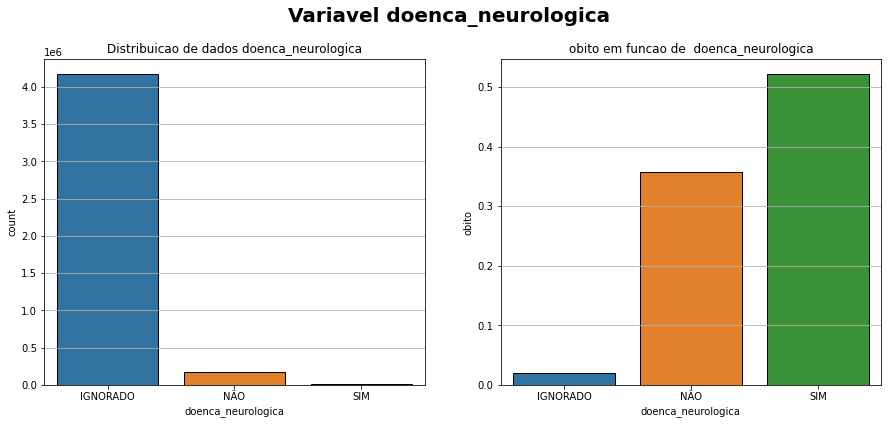

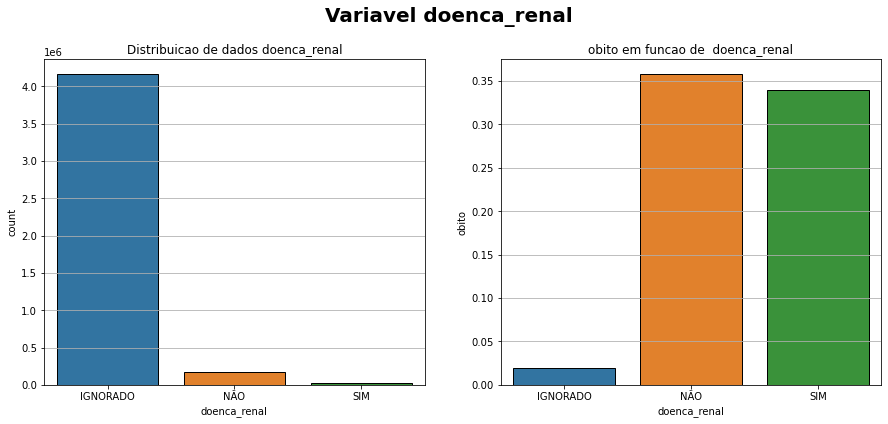

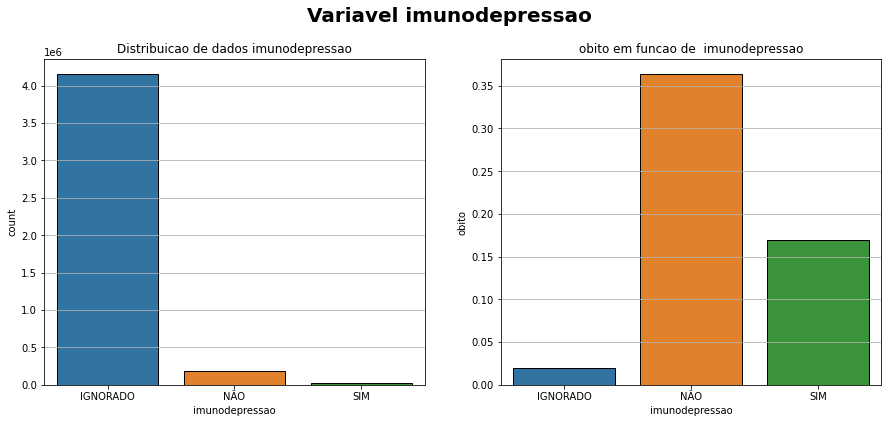

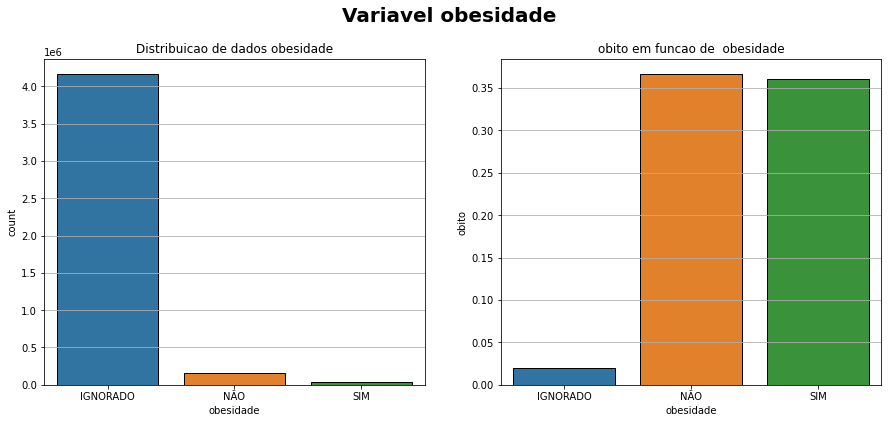

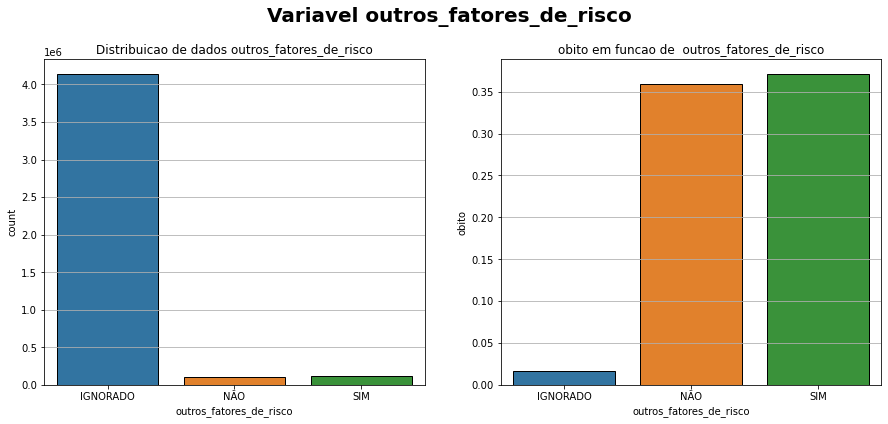

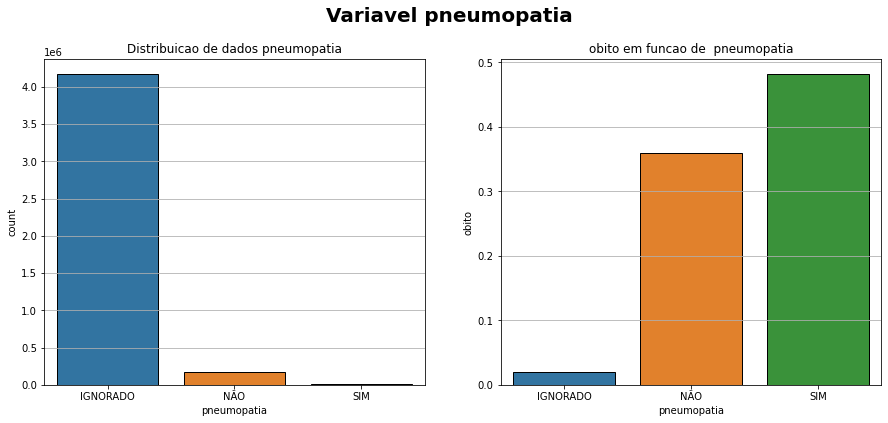

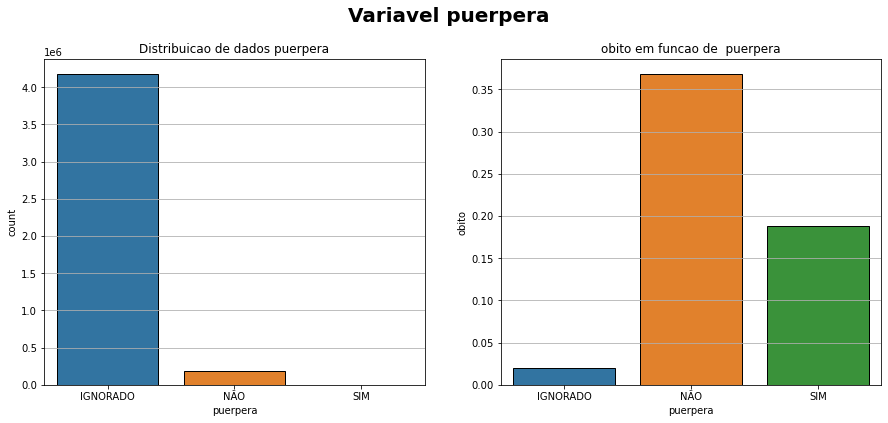

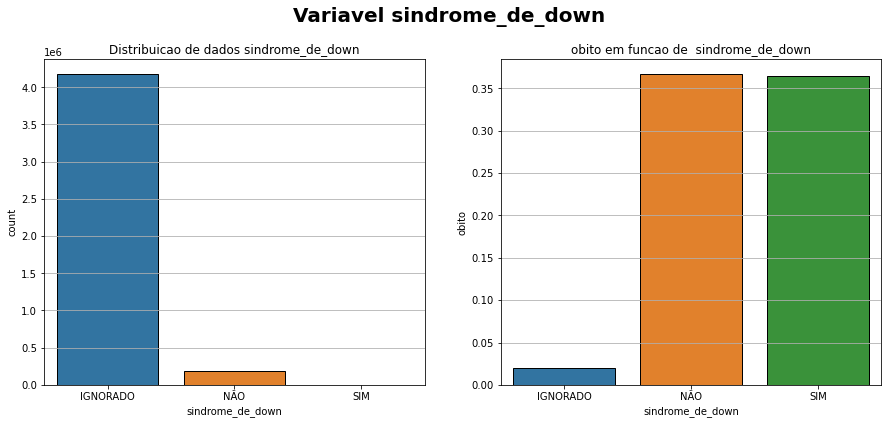

In [7]:
EDA_graphs(df_covid,disc_cols,cont_cols,target)

# 4 - Geoespacial

In [8]:
# Download all municipalities of São Paulo
all_muni = geobr.read_municipality(code_muni="SP", year=2020)

# agrupar os obitos por municipio do estado de são paulo
df_obitos_muni = df_covid[['nome_munic','codigo_ibge','obito']].groupby(by='codigo_ibge',as_index=False).sum()


In [9]:
# merge dos dos dataframes de populacao e idh
df_covid2 = (df_covid
        .merge(df_populacao, how="left", left_on="codigo_ibge", right_on="codigo_ibge")
        .merge(df_idh, how="left", left_on="nome_munic", right_on="nome_munic"))

# groupby para agrupar os dados dos municipios
covid_pivot = df_covid2.groupby(by='codigo_ibge',as_index=False).agg({'obito':'sum', 'media_pop_5anos':'mean', 'idh':'mean'})

# coluna de obitos por 100 mil habitantes
covid_pivot['mortes_per_capita'] = (covid_pivot['obito'] * 100_000 / covid_pivot['media_pop_5anos']).round(1)

# join the databases
all_muni = all_muni.merge(covid_pivot, how="left", left_on="code_muni", right_on="codigo_ibge")

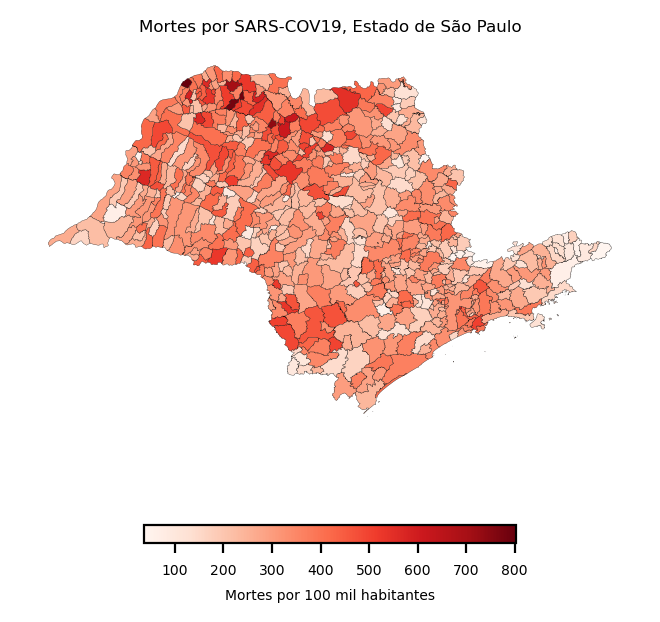

In [10]:
# Mortes por SARS-COV19, nas cidades do estado de São Paulo
plt.rcParams.update({"font.size": 5})

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

all_muni.plot(
    column="mortes_per_capita",
    cmap="Reds",
    legend=True,
    legend_kwds={
        "label": "Mortes por 100 mil habitantes",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    edgecolor="black",
    linewidth=0.1,
    ax=ax,
)

ax.set_title("Mortes por SARS-COV19, Estado de São Paulo")
ax.axis("off")
fig.savefig('figs/obitos_municipio.png')
fig.show()

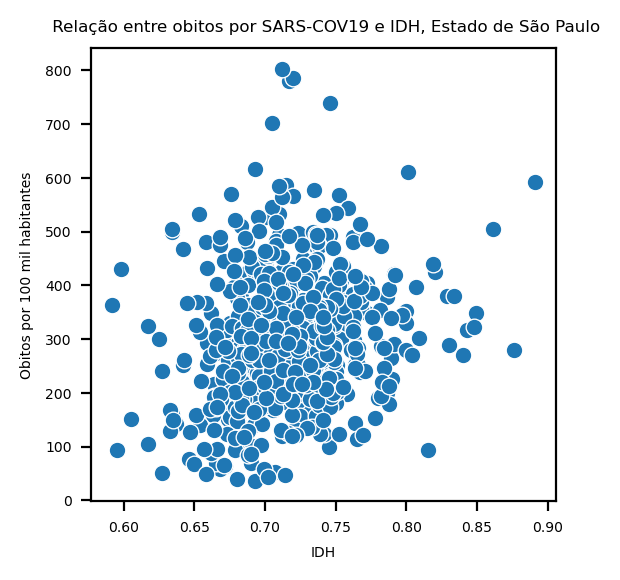

In [11]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

ax = sns.scatterplot(
    data=covid_pivot, 
    x="idh", 
    y="mortes_per_capita")

ax.set_title(" Relação entre obitos por SARS-COV19 e IDH, Estado de São Paulo")
ax.set(xlabel='IDH', ylabel='Obitos por 100 mil habitantes')

plt.show()

# 5 - conclusoes:


FORTE INFLUENCIA
* municipio, isso pode estar relacionado a ocupacao de hospitais ? outras politicas publicas de isolamento ?
* idade, a taxa de sobrevivencia de pessoas mais jovens é maior
* sexo, homens e ignorado tem uma maior chance de obito 
* cardiopatia
* doenca hematologica 
* doenca hepatica 
* doenca neurologica
* outros fatores de risco 
* pneumopatia é um fator de risco 

MODERADA INFLUENCIA
* doenca renal
* obesidade
* sindrome de down

FRACA INFLUENCIA
* asma
* diabetes
* imunodepressao, pessoas com habitos de saúde e higiene bastante rígidos
* puerpera

ANALISE TEMPORAL
* os obitos parecem diminuir com o passar dos meses 

ANALISE GEOGRAFICA
* Alguns municípios menores tiveram um numero alto de obitos e uma pequena população e portanto apresentaram um indice de óbitos por 100 mil habitantes alto

VARIÁVEIS EXOGENAS
* Observase um aumento do número de obitos com o aumento do IDH que é explicado por uma maior circulação de pessoas e mercadorias caracteristicas de regioes de alta atividade comercial e educacional (caracteristicas de alto idh)


# 6 - Referencias

[1] Panorama Populaciona do Etado de São Paulo. IBGE. Disponível em: <https://cidades.ibge.gov.br/brasil/sp/panorama>. Acesso em: 10 de Fev. de 2022
https://github.com/ipeaGIT/geobr
- https://ipeagit.github.io/geobr/articles/python-intro/py-intro-to-geobr.html
- https://basedosdados.org/dataset/br-ibge-populacao
- https://www.kaggle.com/rubensmau/covid-19-deaths-per-capita
- https://towardsdatascience.com/analysis-of-covid-19-using-per-capita-data-f8f9a31a2c4d

- renda/escolaridade/saneamento/basico

variaveis exogenas pelos codigos do municipio
- variaveis socioeconomicas pelo ibge
- http://www.atlasbrasil.org.br/consulta
- ipeadata
- basedosdados